<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Project Overview


This project compares two groups: people who saw an ad and people who saw a PSA.  
It uses two methods: Frequentist (t-test) and Bayesian (Beta distribution).  
The goal is to find out which group had more conversions (purchases).  
The data is also explored by user type, day, and time.  


</div>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/marketing_AB.csv")

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# EDA

   - Basic statistics
   - Conversion rate
   - Conversion rate by user segment (light/medium/heavy)
   - Conversion rate by weekday vs weekend
   - Conversion rate by time of day

</div>

# Basic statistics

In [3]:
def basic_eda_summary(df):

    print("=" * 50)
    print("BASIC EDA SUMMARY")
    print("=" * 50)

    # Shape of the DataFrame
    print("\n[1] Shape of the DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    # Column names
    print("\n[2] Column Names:")
    print(df.columns.tolist())

    # Data types and non-null counts
    print("\n[3] Data Types and Non-Null Counts:")
    print(df.info(memory_usage=False, verbose=True))

    # Missing values per column
    print("\n[4] Missing Values (per column):")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.any() else "No missing values.")

    # Number of unique values per column
    print("\n[5] Number of Unique Values per Column:")
    print(df.nunique())

    # Basic statistics for numeric columns
    print("\n[6] Summary Statistics (numeric columns):")
    print(df.describe())

    print("\nBasic EDA summary complete.")

def detect_categorical_candidates(df, threshold_ratio=0.05, max_display_values=5):

    print("Categorical Feature Candidates\n" + "=" * 40)

    total_rows = len(df)

    for col in df.columns:
        unique_vals = df[col].nunique(dropna=False)
        dtype = df[col].dtype

        # Heuristic 1: object or category dtype with low cardinality
        if dtype == 'object' or dtype.name == 'category':
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — likely categorical (textual)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

        # Heuristic 2: numeric column with low cardinality
        elif unique_vals < total_rows * threshold_ratio:
            print(f"- {col} [type: {dtype}, {unique_vals} unique] — possibly categorical (numeric)")
            sample = df[col].dropna().unique()[:max_display_values]
            print(f"  sample values: {sample} ...\n")

    print("Categorical detection complete.\n")


In [4]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
df[df['test group'] != 'ad'].head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
18,18,900681,psa,False,248,Saturday,19
38,38,905704,psa,False,27,Thursday,8
68,68,904595,psa,False,13,Tuesday,19
140,140,901904,psa,False,32,Wednesday,19
157,157,902234,psa,False,105,Tuesday,19


In [6]:
basic_eda_summary(df)

BASIC EDA SUMMARY

[1] Shape of the DataFrame:
Rows: 588101, Columns: 7

[2] Column Names:
['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads', 'most ads day', 'most ads hour']

[3] Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)None

[4] Missing Values (per column):
No missing values.

[5] Number of Unique Values per Column:
Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day

In [7]:
detect_categorical_candidates(df,threshold_ratio=0.001)

Categorical Feature Candidates
- test group [type: object, 2 unique] — likely categorical (textual)
  sample values: ['ad' 'psa'] ...

- converted [type: bool, 2 unique] — possibly categorical (numeric)
  sample values: [False  True] ...

- most ads day [type: object, 7 unique] — likely categorical (textual)
  sample values: ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday'] ...

- most ads hour [type: int64, 24 unique] — possibly categorical (numeric)
  sample values: [20 22 18 10 14] ...

Categorical detection complete.



# Conversion rate

In [8]:
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['user id'])

group_ad = df[df['test group'] == 'ad']['converted'].astype(float).dropna()
group_psa = df[df['test group'] == 'psa']['converted'].astype(float).dropna()

In [9]:
df['converted'].mean()

np.float64(0.02523886203220195)

In [10]:
df.groupby('test group')['converted'].mean()

test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64

<Axes: xlabel='test group', ylabel='converted'>

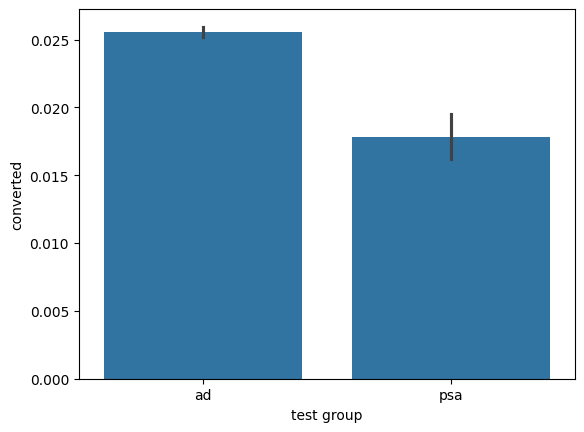

In [11]:
import seaborn as sns
sns.barplot(data=df, x='test group', y='converted')

# Conversion rate by user segment (light/medium/heavy)

In [12]:
q33 = df['total ads'].quantile(0.33)
q66 = df['total ads'].quantile(0.66)

def make_classify_ads(x):
    if x <= q33:
        return 'light'
    elif x <= q66:
        return 'medium'
    else:
        return 'heavy'

df['user_segment'] = df['total ads'].apply(make_classify_ads)

segment_counts_df = df['user_segment'].value_counts().reset_index()
segment_counts_df.columns = ['user_segment', 'count']

conversion_rate_df = df.groupby(['user_segment', 'test group'])['converted'].mean().reset_index()
conversion_rate_df.columns = ['user_segment', 'test_group', 'conversion_rate']

display(segment_counts_df)
display(conversion_rate_df)

,user_segment,count
0,light,201232
1,heavy,199842
2,medium,187027


,user_segment,test_group,conversion_rate
0,heavy,ad,0.065577
1,heavy,psa,0.042109
2,light,ad,0.002579
3,light,psa,0.003033
4,medium,ad,0.007496
5,medium,psa,0.007972


# Conversion rate by weekday vs weekend

In [13]:
# Add new column: weekend or weekday
df['day_type'] = df['most ads day'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'weekday')

# Count rows for each day_type and group
daytype_counts_df = df.groupby(['day_type', 'test group'])['converted'].count().reset_index()
daytype_counts_df.columns = ['day_type', 'test_group', 'count']

# Get conversion rate for each day_type and group
daytype_conversion_df = df.groupby(['day_type', 'test group'])['converted'].mean().reset_index()
daytype_conversion_df.columns = ['day_type', 'test_group', 'conversion_rate']

# Show results
display(daytype_counts_df)
display(daytype_conversion_df)

,day_type,test_group,count
0,weekday,ad,403443
1,weekday,psa,17607
2,weekend,ad,161134
3,weekend,psa,5917


,day_type,test_group,conversion_rate
0,weekday,ad,0.026564
1,weekday,psa,0.018004
2,weekend,ad,0.022999
3,weekend,psa,0.017407


# Conversion rate by time of day

In [14]:
# Define hour category
def make_classify_hour(x):
    if 5 <= x < 12:
        return 'morning'
    elif 12 <= x < 18:
        return 'afternoon'
    else:
        return 'evening'

# Add new column: time segment
df['time_segment'] = df['most ads hour'].apply(make_classify_hour)

# Count rows for each time_segment and group
timesegment_counts_df = df.groupby(['time_segment', 'test group'])['converted'].count().reset_index()
timesegment_counts_df.columns = ['time_segment', 'test_group', 'count']

# Get conversion rate for each time_segment and group
timesegment_conversion_df = df.groupby(['time_segment', 'test group'])['converted'].mean().reset_index()
timesegment_conversion_df.columns = ['time_segment', 'test_group', 'conversion_rate']

# Show results
display(timesegment_counts_df)
display(timesegment_conversion_df)

,time_segment,test_group,count
0,afternoon,ad,246925
1,afternoon,psa,10914
2,evening,ad,180384
3,evening,psa,6860
4,morning,ad,137268
5,morning,psa,5750


,time_segment,test_group,conversion_rate
0,afternoon,ad,0.027668
1,afternoon,psa,0.020158
2,evening,ad,0.025978
3,evening,psa,0.018659
4,morning,ad,0.021163
5,morning,psa,0.012522


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Welch's t-test

We compare the ad and PSA groups using Welch's t-test to see if there is a significant difference in conversion rates.  
If the p-value is below 0.05, we consider the difference statistically significant.  
We also calculate Cohen's d to measure the effect size between the two groups.  
This tells us how big the difference is, not just whether it exists.

</div>

In [15]:
from scipy.stats import ttest_ind

group_ad = df[df['test group'] == 'ad']['converted'].astype(float)
group_psa = df[df['test group'] == 'psa']['converted'].astype(float)

# Welch's t-test（equal_var=False）
t_stat, p_value = ttest_ind(group_ad, group_psa, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value:.4f}")

# α = 0.05
if p_value < 0.05:
    print("There is a statistically significant difference,suggesting a possible effect of the advertisement.")
else:
    print("The results do not show a significant difference, indicating the advertisement may not have a clear effect.")


Welch's t-test: t = 8.6572, p = 0.0000
There is a statistically significant difference,suggesting a possible effect of the advertisement.


In [16]:
import numpy as np

group_ad = df[df['test group'] == 'ad']['converted'].astype(float)
group_psa = df[df['test group'] == 'psa']['converted'].astype(float)

mean_diff = group_ad.mean() - group_psa.mean()
std1 = group_ad.std()
std2 = group_psa.std()

pooled_std = np.sqrt((std1**2 + std2**2) / 2)

# Cohen's d
cohens_d = mean_diff / pooled_std
print(f"Cohen's d: {cohens_d:.4f}")

Cohen's d: 0.0528


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Bayes

First, we count how many users made a purchase and how many did not, for both the ad and PSA groups.  
We use a Beta(1, 1) distribution as the prior, which is a uniform distribution with no bias.  
Then, we update the beta distribution for each group using the observed data.  
Using Monte Carlo simulation, we draw many samples to estimate the posterior distributions.  
Finally, we compare the samples and calculate the probability that the ad group performs better than the PSA group.

</div>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Count conversions and total trials for each group
ad_successes = df[(df['test group'] == 'ad')]['converted'].sum()
ad_trials = df[df['test group'] == 'ad'].shape[0]

psa_successes = df[(df['test group'] == 'psa')]['converted'].sum()
psa_trials = df[df['test group'] == 'psa'].shape[0]

# Set beta distribution parameters (with flat prior)
ad_alpha, ad_beta = ad_successes + 1, ad_trials - ad_successes + 1
psa_alpha, psa_beta = psa_successes + 1, psa_trials - psa_successes + 1

# Draw samples from the posterior (Monte Carlo)
samples = 100_000
ad_samples = np.random.beta(ad_alpha, ad_beta, samples)
psa_samples = np.random.beta(psa_alpha, psa_beta, samples)

# Print sample results
print('ad_samples')
print(ad_samples)
print('psa_samples')
print(psa_samples)


ad_samples
[0.02556969 0.02536439 0.02561766 ... 0.02575342 0.0254457  0.02555029]
psa_samples
[0.0192191  0.01691424 0.01780738 ... 0.01953193 0.01827714 0.01832025]


In [18]:
# The probability that the Ad group has a higher CVR
prob_ad_better = (ad_samples > psa_samples).mean()

print(f"The chance that the Ad group has a higher CVR than the PSA group is {prob_ad_better:.4f}.")


The chance that the Ad group has a higher CVR than the PSA group is 1.0000.


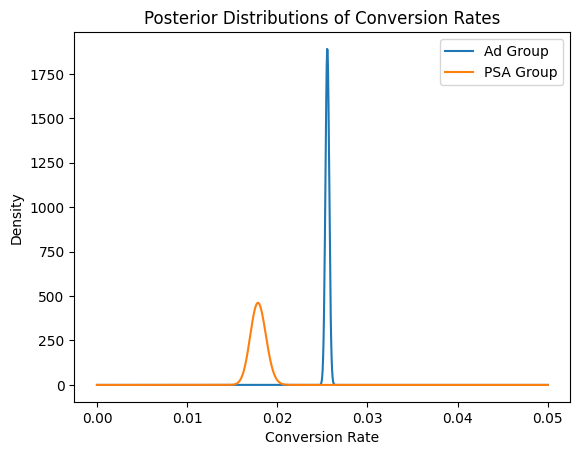

In [19]:
x = np.linspace(0, 0.05, 1000)
plt.plot(x, beta.pdf(x, ad_alpha, ad_beta), label='Ad Group')
plt.plot(x, beta.pdf(x, psa_alpha, psa_beta), label='PSA Group')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Posterior Distributions of Conversion Rates')
plt.legend()
plt.show()


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Conclusion

Both Welch’s t-test and Bayesian analysis showed that the Ad group performed better than the PSA group.  
From the EDA, we found that this effect was stronger among users with higher usage frequency.  

While the Ad group is almost certainly better, it is recommended to focus on high-frequency users first when switching from PSA to Ad.  

</div>